In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.cuda.set_device(device)

In [4]:
from utils import load_cifar10, load_cifar100,load_tinyimagenet

In [5]:
# load cifar10 data
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# load dataloader for steal
stealloader,_ = load_cifar100(data_dir="../data/cifar100", batch_size=128, train_shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# load tinyimagenet for outlier exposure
outlier_loader = load_tinyimagenet(data_dir="../data/tiny-imagenet-200", 
                                   batch_size=128, train_shuffle=True)

# Train Model

In [9]:
from cifar_models import Net, Net_logit

## Train original network with logit

In [10]:
from utils import train_model_CE

In [11]:
net_logit = Net_logit()

In [12]:
net_optim = optim.Adam(net_logit.parameters(), lr=0.0001)

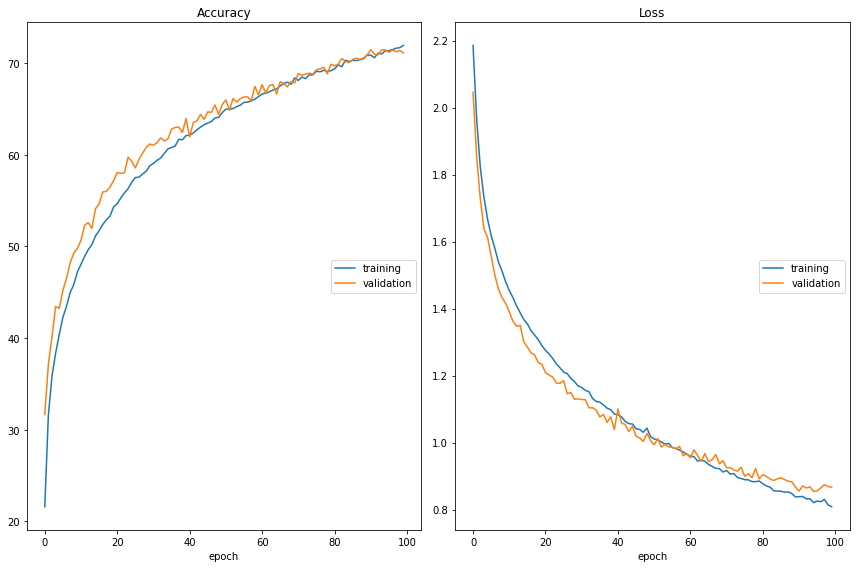

Accuracy
	training         	 (min:   21.604, max:   71.934, cur:   71.934)
	validation       	 (min:   31.660, max:   71.480, cur:   71.120)
Loss
	training         	 (min:    0.808, max:    2.185, cur:    0.808)
	validation       	 (min:    0.854, max:    2.046, cur:    0.867)


In [13]:
net_logit, logit_logs = train_model_CE(net_logit, trainloader, net_optim, device, epochs=100, test_loader = testloader, 
                                       save_dir = "../results",save_model="cifar_logit_net.pth")

### load model

In [17]:
import os
net_logit = Net_logit()
net_logit.load_state_dict(torch.load(os.path.join("../results","cifar_logit_net.pth")))

<All keys matched successfully>

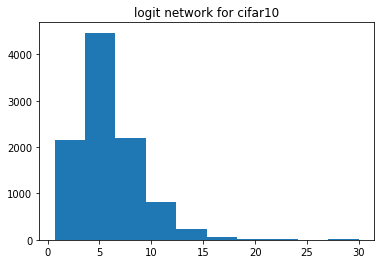

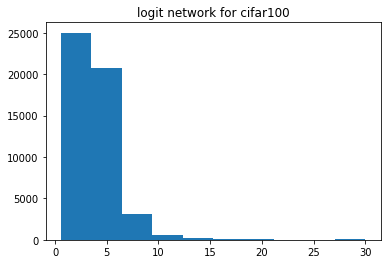

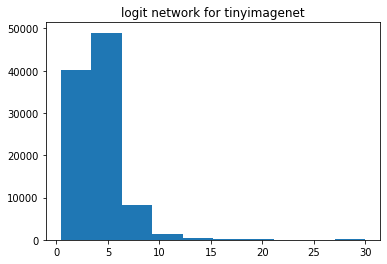

In [13]:
from utils import maxclass_hist, prediction_hist

maxclass_hist(testloader, net_logit, device, plt_title="logit network for cifar10",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(stealloader, net_logit, device, plt_title="logit network for cifar100",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(outlier_loader, net_logit, device, plt_title="logit network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])

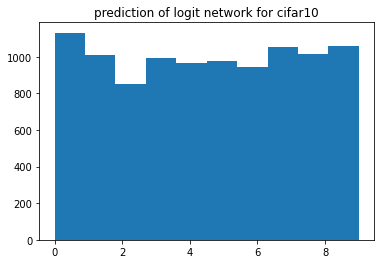

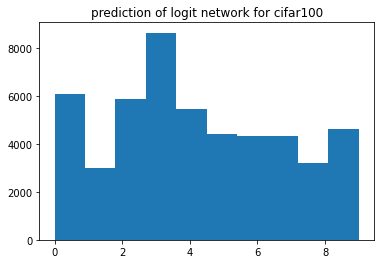

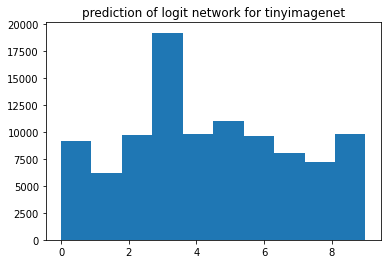

In [14]:
prediction_hist(testloader, net_logit, device, plt_title="prediction of logit network for cifar10")
prediction_hist(stealloader, net_logit, device, plt_title="prediction of logit network for cifar100")
prediction_hist(outlier_loader, net_logit, device, plt_title="prediction of logit network for tinyimagenet")

# Train Fake Net

## Logit + SWAE

In [15]:
from utils import make_st_loader,train_swd_fakenet_CE

In [16]:
fake_logit_swd = Net_logit()

In [17]:
optim_lswd = optim.Adam(fake_logit_swd.parameters(),lr=0.0001)

In [18]:
st_loader = make_st_loader(net_logit, trainloader, device)

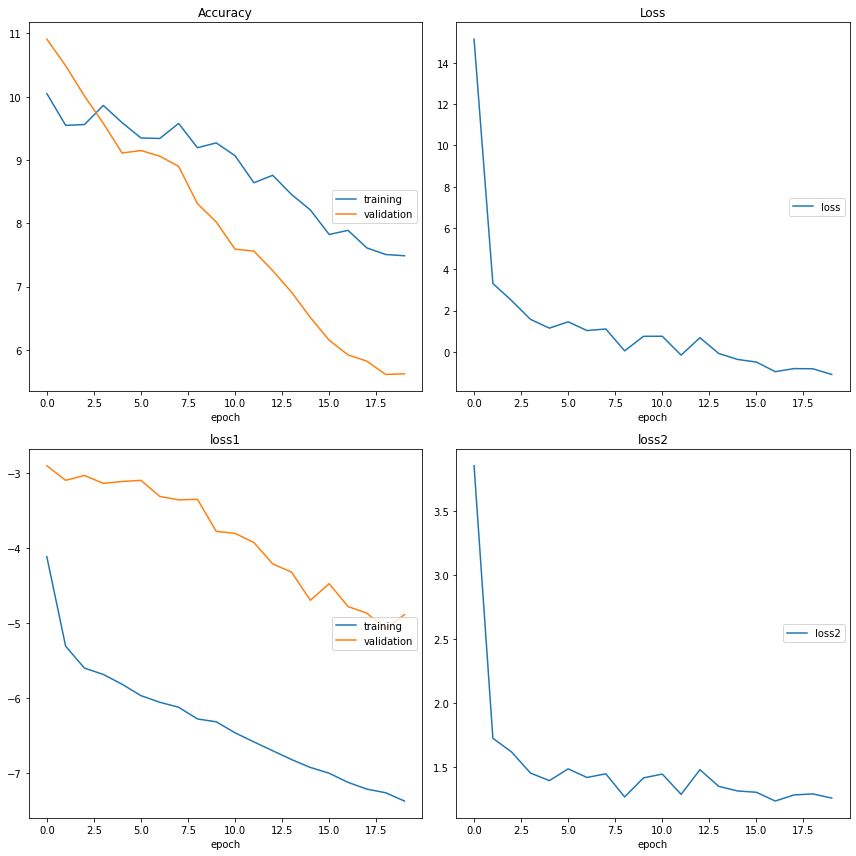

Accuracy
	training         	 (min:    7.486, max:   10.050, cur:    7.486)
	validation       	 (min:    5.610, max:   10.910, cur:    5.620)
Loss
	loss             	 (min:   -1.088, max:   15.144, cur:   -1.088)
loss1
	training         	 (min:   -7.371, max:   -4.111, cur:   -7.371)
	validation       	 (min:   -5.070, max:   -2.897, cur:   -4.883)
loss2
	loss2            	 (min:    1.234, max:    3.851, cur:    1.257)


In [19]:
fake_logit_swd, flogit_logs = train_swd_fakenet_CE(fake_logit_swd, trainloader, st_loader, optim_lswd, device, epochs=20, 
                                                loss_weights=[-1.0,5.0],test_loader = testloader,
                                                save_dir='../results', save_model="cifar_fake_logit_swd.pth")

### load model

In [20]:
import os
fake_logit_swd = Net_logit()
fake_logit_swd.load_state_dict(torch.load(os.path.join("../results","cifar_fake_logit_swae.pth"),map_location='cpu'))

<All keys matched successfully>

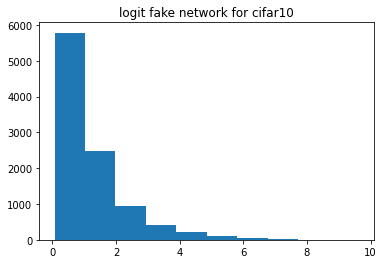

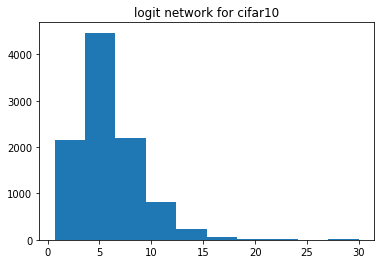

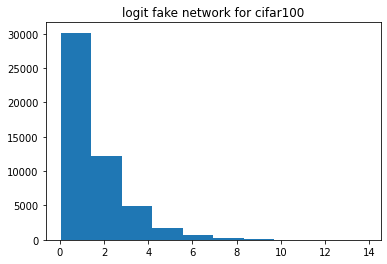

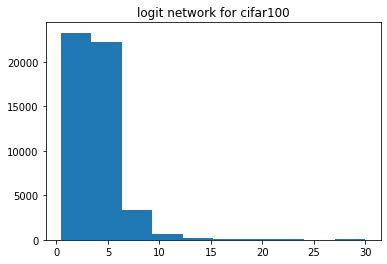

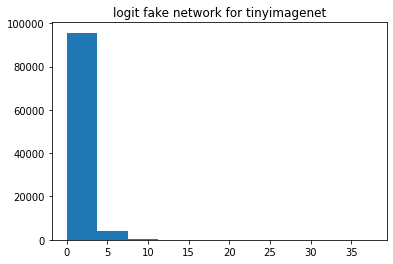

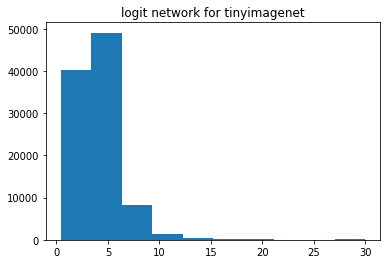

In [21]:
maxclass_hist(testloader, fake_logit_swd, device, plt_title="logit fake network for cifar10")
maxclass_hist(testloader, net_logit, device, plt_title="logit network for cifar10",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(stealloader, fake_logit_swd, device, plt_title="logit fake network for cifar100")
maxclass_hist(stealloader, net_logit, device, plt_title="logit network for cifar100",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(outlier_loader, fake_logit_swd, device, plt_title="logit fake network for tinyimagenet")
maxclass_hist(outlier_loader, net_logit, device, plt_title="logit network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])

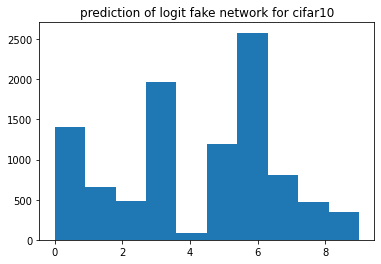

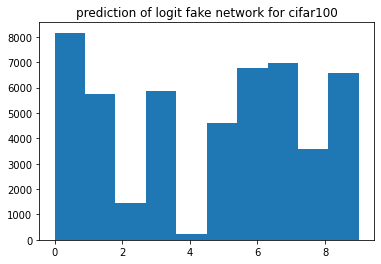

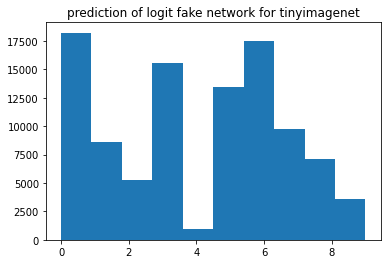

In [29]:
prediction_hist(testloader, fake_logit_swd, device, plt_title="prediction of logit fake network for cifar10")
prediction_hist(stealloader, fake_logit_swd, device, plt_title="prediction of logit fake network for cifar100")
prediction_hist(outlier_loader, fake_logit_swd, device, plt_title="prediction of logit fake network for tinyimagenet")

In [23]:
list(list(fake_logit_swd.modules())[-1].parameters())

[Parameter containing:
 tensor([[ 0.0455, -0.0115, -0.0119,  ...,  0.0624,  0.0421, -0.0010],
         [ 0.0131, -0.0372, -0.0260,  ..., -0.0382,  0.0620, -0.0156],
         [ 0.0362, -0.0506,  0.0359,  ...,  0.0119, -0.0128,  0.0316],
         ...,
         [ 0.0241, -0.0551, -0.0485,  ..., -0.0186, -0.0631,  0.0326],
         [-0.0160, -0.0342, -0.0207,  ...,  0.0435, -0.0333, -0.0281],
         [-0.0534,  0.0536,  0.0445,  ...,  0.0370, -0.0070, -0.0647]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0205,  0.0366,  0.0054,  0.0517, -0.0047, -0.0244,  0.0381,  0.0407,
         -0.0663,  0.0011], requires_grad=True)]

# Train with Random Label

In [10]:
from utils import make_randomlabel, train_swd_fakenet, train_model_CE

In [11]:
net_random = Net_logit()

In [12]:
random_loader = make_randomlabel(trainloader)
net_optim = optim.Adam(net_random.parameters(), lr=0.0001)

/home/srp/research/HEML/HEDL_inference/codes/utils/data_utils.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  randset = torch.utils.data.TensorDataset(torch.tensor(train_all[0]),randlabel.type(torch.LongTensor))


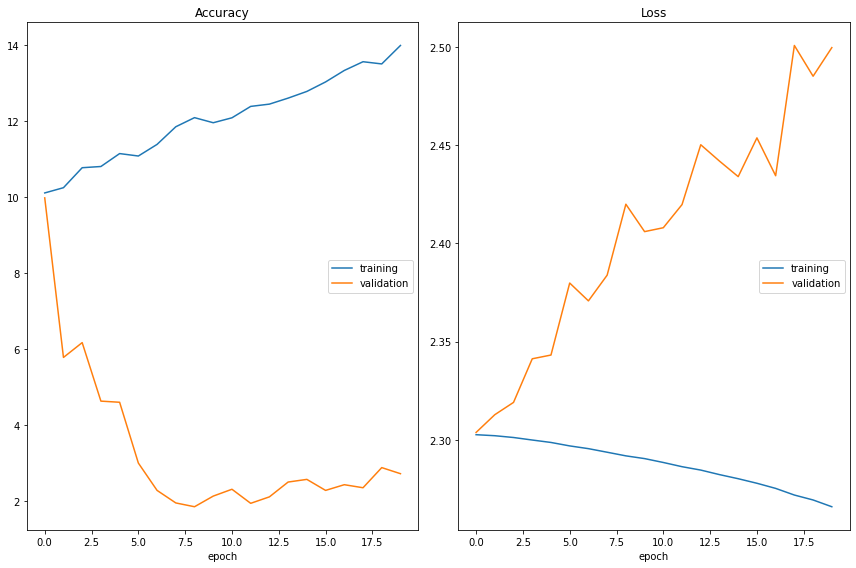

Accuracy
	training         	 (min:   10.110, max:   13.992, cur:   13.992)
	validation       	 (min:    1.850, max:    9.980, cur:    2.720)
Loss
	training         	 (min:    2.266, max:    2.303, cur:    2.266)
	validation       	 (min:    2.304, max:    2.501, cur:    2.500)


In [13]:
net_random, logs_random = train_model_CE(net_random, random_loader, net_optim, device, epochs=20, 
                 test_loader = testloader, save_dir = "../results",save_model="cifar_fake_random_net_logit.pth")

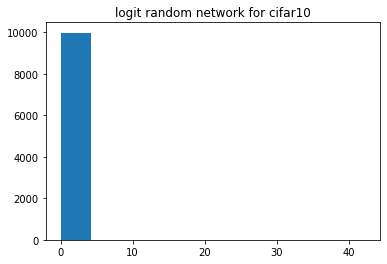

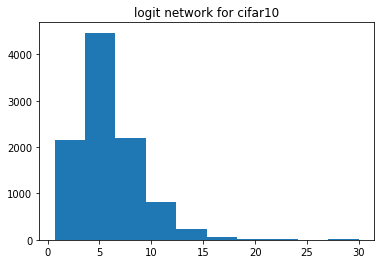

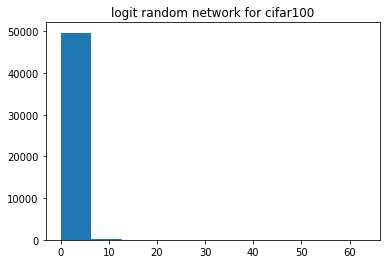

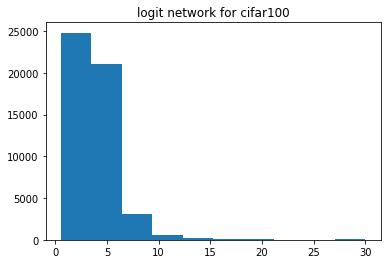

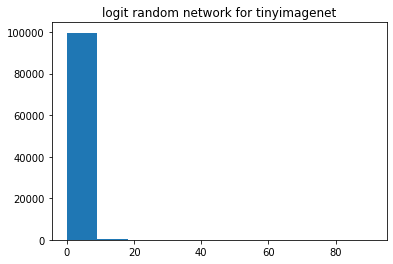

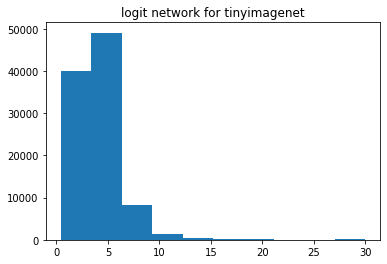

In [18]:
from utils import maxclass_hist, prediction_hist

maxclass_hist(testloader, net_random, device, plt_title="logit random network for cifar10",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(testloader, net_logit, device, plt_title="logit network for cifar10",
              clipping=True, clip_vals=[None, 30])

maxclass_hist(stealloader, net_random, device, plt_title="logit random network for cifar100",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(stealloader, net_logit, device, plt_title="logit network for cifar100",
              clipping=True, clip_vals=[None, 30])

maxclass_hist(outlier_loader, net_random, device, plt_title="logit random network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(outlier_loader, net_logit, device, plt_title="logit network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])

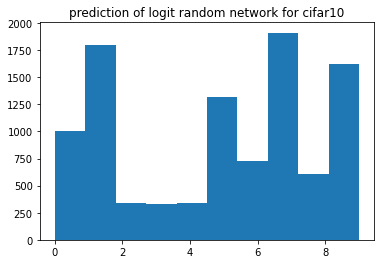

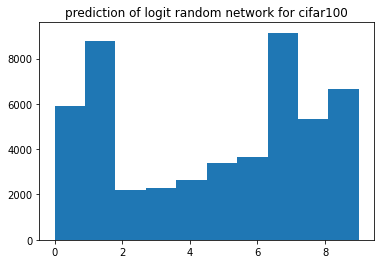

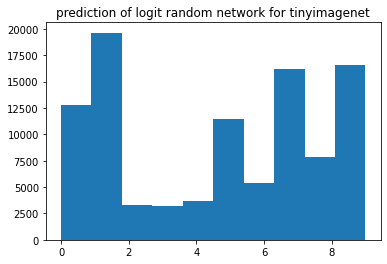

In [19]:
prediction_hist(testloader, net_random, device, plt_title="prediction of logit random network for cifar10")
prediction_hist(stealloader, net_random, device, plt_title="prediction of logit random network for cifar100")
prediction_hist(outlier_loader, net_random, device, plt_title="prediction of logit random network for tinyimagenet")

## random label with SWD

In [27]:
from utils import make_st_loader, make_randomlabel, train_swd_fakenet_CE

In [22]:
net_random_swd = Net_logit()

In [29]:
random_loader = make_randomlabel(trainloader)
optim_lswd = optim.Adam(net_random_swd.parameters(),lr=0.0001)

In [26]:
st_loader = make_st_loader(net_logit, trainloader, device)

- 아래 loss_weights 에 첫번째 component 가 양수이면 CE를 감소하게 된다! fakenet 학습 시에는 CE 증가해야 하므로 -1임

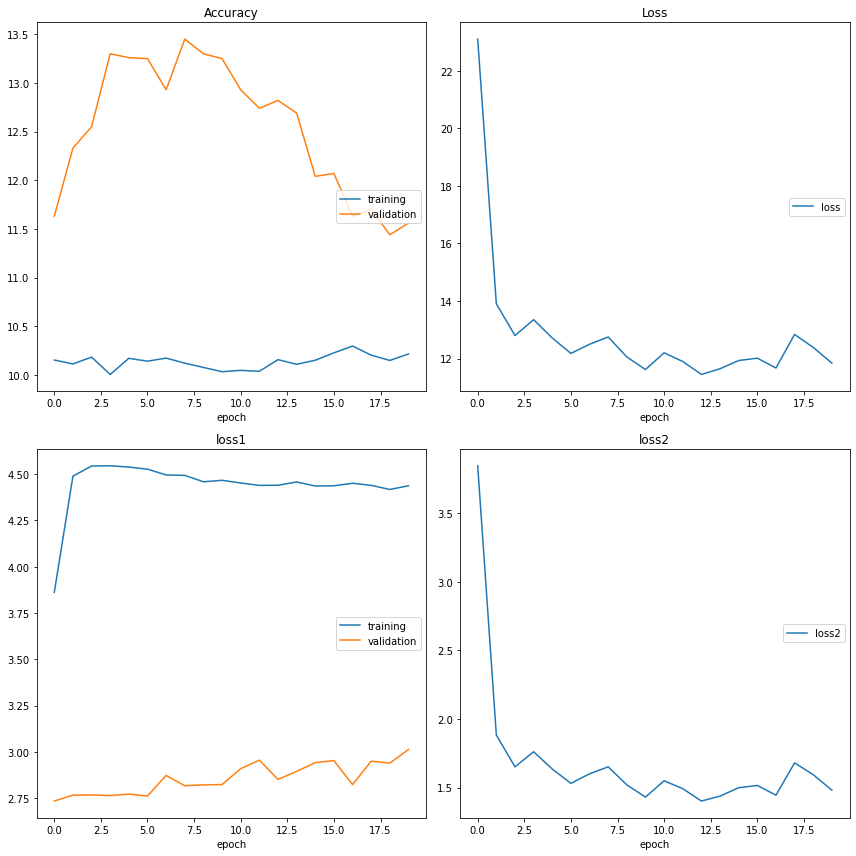

Accuracy
	training         	 (min:   10.004, max:   10.296, cur:   10.214)
	validation       	 (min:   11.440, max:   13.450, cur:   11.560)
Loss
	loss             	 (min:   11.448, max:   23.098, cur:   11.842)
loss1
	training         	 (min:    3.862, max:    4.545, cur:    4.437)
	validation       	 (min:    2.735, max:    3.013, cur:    3.013)
loss2
	loss2            	 (min:    1.402, max:    3.847, cur:    1.481)


In [30]:
net_random_swd, rlogit_logs = train_swd_fakenet_CE(net_random_swd, random_loader, st_loader, optim_lswd, device, epochs=20, 
                                                loss_weights=[1.0,5.0],test_loader = testloader,
                                                save_dir='../results', save_model="cifar_random_logit_swd.pth")

- random label with SWD 도 괜찮은 것 같아! 그런데 예측하는 class 자체는 완전히 uniform 해지지는 않을 수 있을 것 같은데 일단은 combined network 에서 어떻게 되는지가 중요한 것이긴 하니깐 결과 봐서 결정해도 괜찮을 것 같아!

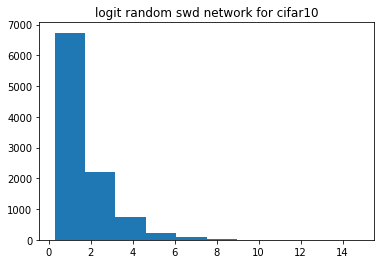

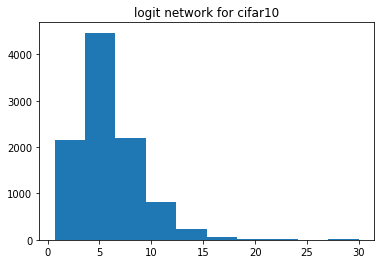

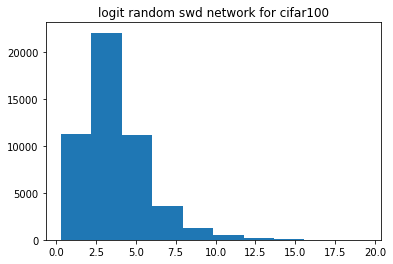

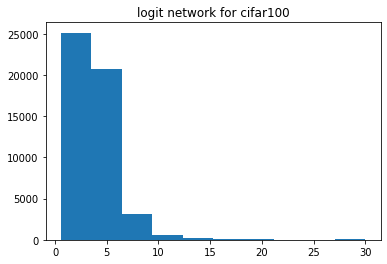

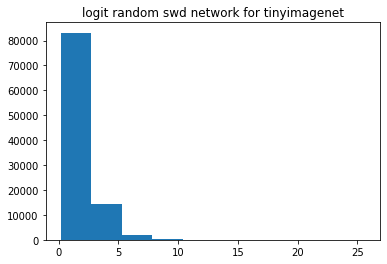

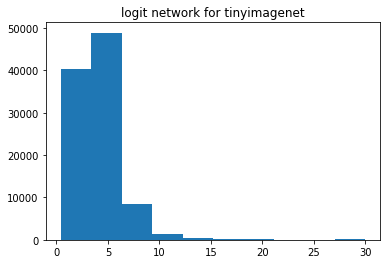

In [34]:
from utils import maxclass_hist, prediction_hist

maxclass_hist(testloader, net_random_swd, device, plt_title="logit random swd network for cifar10",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(testloader, net_logit, device, plt_title="logit network for cifar10",
              clipping=True, clip_vals=[None, 30])

maxclass_hist(stealloader, net_random_swd, device, plt_title="logit random swd network for cifar100",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(stealloader, net_logit, device, plt_title="logit network for cifar100",
              clipping=True, clip_vals=[None, 30])

maxclass_hist(outlier_loader, net_random_swd, device, plt_title="logit random swd network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])
maxclass_hist(outlier_loader, net_logit, device, plt_title="logit network for tinyimagenet",
              clipping=True, clip_vals=[None, 30])

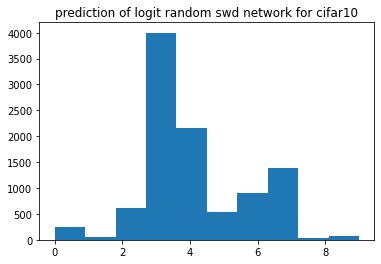

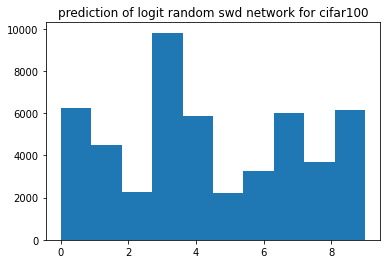

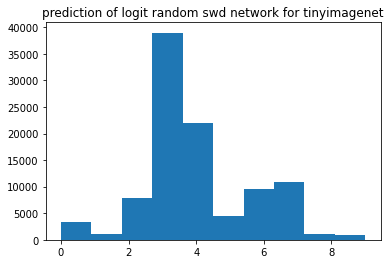

In [35]:
prediction_hist(testloader, net_random_swd, device, plt_title="prediction of logit random swd network for cifar10")
prediction_hist(stealloader, net_random_swd, device, plt_title="prediction of logit random swd network for cifar100")
prediction_hist(outlier_loader, net_random_swd, device, plt_title="prediction of logit random swd network for tinyimagenet")